In [1]:
import csv
import json
import urllib.request
import requests
import uuid
import time
import yaml
from os import path
from pathlib import Path
from string import Template
from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
from tqdm import tqdm

In [2]:
configFile = '../pipeline/config.yml'

### Load Configuration

In [3]:
try:
    with open(configFile, 'r') as f:
        config = yaml.safe_load(f)
except:
    raise Exception("Could not load config file at", configFile)

### Define helpers

In [4]:
# Constants
SPARQL = 0
CSV = 1

def sparqlResultToDict(results):
    rows = []
    for result in results["results"]["bindings"]:
        row = {}
        for key in results["head"]["vars"]:
            if key in result:
                row[key] = result[key]["value"]
            else:
                row[key] = None
        rows.append(row)
    return rows

def writeData(data):
    try:
        with open(config['dataFile'], 'w') as f:
            writer = csv.DictWriter(f, fieldnames=['id','image','width','height','documentCoordinates'])
            writer.writeheader()
            for row in data:
                if not 'documentCoordinates' in row:
                    row['documentCoordinates'] = None
                writer.writerow(row)
    except:
        raise Exception("Could not write to", config['dataFile'])

## Step 1: Get input data

In [5]:
mode = False
if config['mode'] == "SPARQL":
    mode = SPARQL
elif config['mode'] == "CSV":
    mode  = CSV
else:
    raise Exception("mode not specified or invalid (should be SPARQL or CSV)")

Read data from input file, if present. This is being done for both CSV and SPARQL mode as the SPARQL results will be cashed in the CSV file and updated when data is changed.

In [6]:
inputData = []
try:
    with open(config['dataFile'], 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            inputData.append({
                "id": row['id'],
                "image": row['image'],
                "width": row['width'],
                "height": row['height'],
                "documentCoordinates": row['documentCoordinates'] if 'documentCoordinates' in row else None
            })
except:
    print("No prior input file found")


If in SPARQL mode, get data from SPARQL endpoint

In [7]:
if mode == SPARQL:
    if not config['endpoint'] or not config['query']:
        raise Exception("incomplete configuration for SPARQL mode")
        
    sparql = SPARQLWrapper(config['endpoint'], returnFormat=JSON)
    sparql.setQuery(config['query'])
    try:
        ret = sparql.query().convert()
    except:
        raise Exception("Could not execute query against endpoint", config['endpoint'])
    queriedData = sparqlResultToDict(ret)

If in SPARQL mode, merge queried data with data stored in CSV file.
- add entries that exist in SPARQL result, but not in the CSV file
- add width/height information when it is only available in either the CSV file or the SPARQL output (prioritising the SPARQL data)
Store merged data in CSV file

In [8]:
data = inputData

if mode == SPARQL:
    inputDataHash = {}
    queriedDataHash = {}

    for row in inputData:
        inputDataHash[row['id']] = row
    for row in queriedData:
        queriedDataHash[row['id']] = row

    idsInInputData = [d['id'] for d in inputData]
    for row in queriedData:
        if row['id'] not in idsInInputData:
            data.append(row)

    for row in data:
        if not row['width']:
            if row['id'] in queriedDataHash and queriedDataHash[row['id']]['width']:
                row['width'] = queriedDataHash[row['id']]['width']
            elif row['id'] in inputDataHash and inputDataHash[row['id']]['width']:
                row['width'] = inputDataHash[row['id']]['width']
        if not row['height']:
            if row['id'] in queriedDataHash and queriedDataHash[row['id']]['height']:
                row['height'] = queriedDataHash[row['id']]['height']
            elif row['id'] in inputDataHash and inputDataHash[row['id']]['width']:
                row['height'] = inputDataHash[row['id']]['height']
    
    writeData(data)

## Step 2: Get (missing) image sizes

If the original image size is not specified, call the IIIF Image API to read the size from the JSON rsponse

In [9]:
for row in tqdm(data):
    if not row['width'] or not row['height']:
        uri = row['image'] + '/info.json'
        try:
            with urllib.request.urlopen(uri) as url:
                manifestData = json.loads(url.read().decode())
                
        except:
            print("Could not open", uri)
            next
        row['width'] = manifestData['width']
        row['height'] = manifestData['height']
        writeData(data)

100%|██████████| 7621/7621 [00:00<00:00, 111959.17it/s]


Write data to file

In [10]:
writeData(data)

## Step 3: Download images

Download the images that do not yet exist in the image folder. The images will be downloaded resized to a width of 1024 pixels.

In [11]:
try:
    Path(config['imageDirectory']).mkdir(parents=True, exist_ok=True)
except:
    raise Exception("Could not add/access folder", config['imageDirectory'])

In [12]:
maxRetries = 5
for row in tqdm(data):
    filename = path.join(config['imageDirectory'], row['id'] + '.jpg')
    if not path.exists(filename):
        url = row['image'] + '/full/1024,/0/default.jpg'
        r = requests.get(url, allow_redirects = True)
        retries = 1
        while not 'image' in r.headers['Content-Type'] and retries <= maxRetries:
            # Try again if no image comes back
            time.sleep(1)
            r = requests.get(url, allow_redirects = True)
            retries += 1
        if retries >= maxRetries:
            print("Could not download", row['id'])
        else:
            with open(filename, 'wb') as f:
                f.write(r.content)

100%|██████████| 7621/7621 [00:01<00:00, 7363.84it/s]


## Step 4: Detect Images

In [13]:
import cv2
import random
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from IPython.display import display

 33%|███▎      | 2496/7621 [00:01<00:02, 2122.38it/s] 


Exception: ('Could not write to', '../data/data.csv')

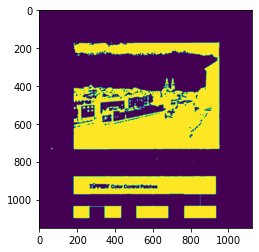

In [14]:
extension = 50

for row in tqdm(data):
    if not row['documentCoordinates'] or len(row['documentCoordinates']) == 0:
        filename = path.join(config['imageDirectory'], row['id'] + '.jpg')
        # Load image
        image = cv2.imread(filename)
    
        # Extend image border
        extendedImage = cv2.copyMakeBorder(image,extension,extension,extension,extension,cv2.BORDER_REPLICATE)
        
        # Convert to grayscale and blur
        gray = cv2.cvtColor(extendedImage.copy(), cv2.COLOR_RGB2GRAY)
        gray = cv2.blur(gray, (5, 5))
        
        # Binarise
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        plt.imshow(Image.fromarray(thresh))
        
        # Detect contours
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_contours = np.zeros(extendedImage.shape)
        cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
        
        # Identify biggest contour
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)
        img = np.zeros(extendedImage.shape)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        
        # Remove frame
        x = x - extension if x > extension else 0
        y = y - extension if y > extension else 0
        
        # Upscale to original size
        row['documentCoordinates'] = "%d,%d,%d,%d" % (int( x / 1024 * int(row['width'])),
                                                      int( y / 1024 * int(row['height'])),
                                                      int( w / 1024 * int(row['width'])),
                                                      int( h / 1024 * int(row['height'])))

        # Store coordinates in data after every prediction
        writeData(data)

## Step 5: Output as CIDOC-CRM RDF

Output as a Trig file that can be displayed and edited in the Mirador component of ResearchSpace & Metaphacts

In [15]:
namespaces = """
PREFIX Platform: <http://www.metaphacts.com/ontologies/platform#> 
PREFIX User: <http://www.metaphacts.com/resource/user/> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 
PREFIX crmdig: <http://www.ics.forth.gr/isl/CRMdig/> 
PREFIX rso: <http://www.researchspace.org/ontology/> 
PREFIX prov: <http://www.w3.org/ns/prov#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX ldp: <http://www.w3.org/ns/ldp#> 
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
"""

static = """

<https://platform.swissartresearch.net/imageRegions> {
    <https://resource.swissartresearch.net/type/imageRegion> a crm:E55_Type ;
    rdfs:label "Image Region" ;
    crm:P3_has_note "A region defining the visual image represented within a digital image. For example, the region denotes the visual item that is reproduced on a document which is photographed.".
}
"""

regionTemplate = Template('''<$uri/container/context> {
  Platform:formContainer ldp:contains <$uri/container> .
  
  <$uri>
    a crmdig:D35_Area, rso:EX_Digital_Image_Region;
    crmdig:L49_is_primary_area_of <$iiifImage>;
    crm:P33_used_specific_technique <https://github.com/swiss-art-research-net/bso-image-segmentation> ;
    rso:boundingBox "xywh=$x,$y,$w,$h";
    rso:displayLabel "image";
    rso:viewport "xywh=0,0,0,0";
    rdf:value "<svg xmlns='http://www.w3.org/2000/svg'><path xmlns=\\"http://www.w3.org/2000/svg\\" d=\\"M${x0},${y0}l${halfW},0l0,0l${halfW},0l 0,${halfH}l 0,${halfH}l -${halfW},0l -${halfW},0l 0,-${halfH}z\\" data-paper-data=\\"{&quot;defaultStrokeValue&quot;:1,&quot;editStrokeValue&quot;:5,&quot;currentStrokeValue&quot;:1,&quot;rotation&quot;:0,&quot;deleteIcon&quot;:null,&quot;rotationIcon&quot;:null,&quot;group&quot;:null,&quot;editable&quot;:true,&quot;annotation&quot;:null}\\" id=\\"rectangle_e880ad36-1fef-4ce3-835d-716ba7db628a\\" fill-opacity=\\"0\\" fill=\\"#00bfff\\" fill-rule=\\"nonzero\\" stroke=\\"#00bfff\\" stroke-width=\\"4.04992\\" stroke-linecap=\\"butt\\" stroke-linejoin=\\"miter\\" stroke-miterlimit=\\"10\\" stroke-dasharray=\\"\\" stroke-dashoffset=\\"0\\" font-family=\\"none\\" font-weight=\\"none\\" font-size=\\"none\\" text-anchor=\\"none\\" style=\\"mix-blend-mode: normal\\"/></svg>" .
  
  <$uri/container>
    a ldp:Resource, prov:Entity;
    prov:generatedAtTime "$dateTime"^^xsd:dateTime;
    prov:wasAttributedTo User:admin .
}

<https://platform.swissartresearch.net/imageRegions> {
    <$uri> crm:P2_has_type <https://resource.swissartresearch.net/type/imageRegion> .
}

''')

In [17]:
dateTime = datetime.now().strftime("%Y-%m-%dT%H:%M:%S+00:00z")

output = namespaces + static

missingDocumentCoordinates = []

for row in tqdm(data):
    if row['documentCoordinates'] is None:
        missingDocumentCoordinates.append(row)
        continue
        
    docCoords = row['documentCoordinates'].split(',')
    
    if len(docCoords) < 4:
        missingDocumentCoordinates.append(row)
        continue

    x = int(docCoords[0])
    y = int(docCoords[1])
    w = int(docCoords[2])
    h = int(docCoords[3])

    edges = {
        "topLeft": (x, y),
        "topRight": (x + w, y),
        "bottomRight": (x + w, y + h),
        "bottomLeft": (x, y + h)
    }
    iiifImage = row['image']
    identifier = str(uuid.uuid3(uuid.NAMESPACE_DNS, iiifImage))
    uri = "https://resource.swissartresearch.net/digitalobject/" + identifier
    x0 = edges['topLeft'][0]
    y0 = edges['topLeft'][1]
    x1 = edges['bottomRight'][0]
    y1 = edges['bottomRight'][1]
    x = x0
    y = y0
    w = x1 - x0
    h = y1 - y0
    output += regionTemplate.substitute(
        uri=uri,
        iiifImage=iiifImage,
        x=int(x),
        y=int(y),
        w=int(w),
        h=int(h),
        x0=x0,
        y0=y0,
        halfW=float(w/2),
        halfH=float(h/2),
        dateTime=dateTime
    )

# Write summary of missing corodinates
if len(missingDocumentCoordinates) > 0:
    print("Could not detect coordinates in %d images:" % len(missingDocumentCoordinates))
    print('\n'.join([d['id'] for d in missingDocumentCoordinates]))
    
filename = path.join(config['trigFile'])
with open(filename, 'w') as f:
    f.write(output)

100%|██████████| 7621/7621 [00:00<00:00, 45739.98it/s]


Could not detect coordinates in 5124 images:
zbz-990101384460205508
zbz-990101385320205508
zbz-990101385810205508
zbz-990101385890205508
zbz-990101386190205508
zbz-990101386230205508
zbz-990101386250205508
zbz-990101386260205508
zbz-990101386270205508
zbz-990101386290205508
zbz-990101386310205508
zbz-990101386340205508
zbz-990101387250205508
zbz-990101387310205508
zbz-990101387410205508
zbz-990101388390205508
zbz-990101388490205508
zbz-990101388550205508
zbz-990101388620205508
zbz-990101388680205508
zbz-990101389770205508
zbz-990101390910205508
zbz-990101392100205508
zbz-990101393720205508
zbz-990101394120205508
zbz-990101394810205508
zbz-990101395000205508
zbz-990101395600205508
zbz-990101395750205508
zbz-990101395900205508
zbz-990101396340205508
zbz-990101396530205508
zbz-990101396560205508
zbz-990101396560205508
zbz-990101396730205508
zbz-990101397200205508
zbz-990101397290205508
zbz-990101397360205508
zbz-990101397590205508
zbz-990101397600205508
zbz-990101397740205508
zbz-99010139